## 卷积神经网络（Convolutional Neural Network, CNN）

## 项目：实现一个狗品种识别算法

在这个项目的最后，能够根据提供的任何一个图像作为输入。如果可以从图像中检测到一只狗，它会输出对狗品种的预测。如果图像中是一个人脸，它会预测一个与其最相似的狗的种类。下面这张图展示了完成项目后可能的输出结果。

![Sample Dog Output](images/sample_dog_output.png)

用来预测狗种类的算法会与预测人脸的算法不同，需要拼凑这两个模型来完成不同的任务。

### 项目内容

这个notebook分为不同的步骤。

* [Step 0](#step0): 导入数据集
* [Step 1](#step1): 检测人脸
* [Step 2](#step2): 检测狗狗
* [Step 3](#step3): 从头创建一个CNN来分类狗品种
* [Step 4](#step4): 使用迁移学习来分类狗的品种1
* [Step 5](#step5): 建立迁移学习来分类狗的品种2
* [Step 6](#step6): 完成你的算法
* [Step 7](#step7): 测试你的算法

---

<a id='step0'></a>
## 步骤 0: 导入数据集

### 导入狗数据集
导入一个狗图像的数据集。使用 scikit-learn 库中的 `load_files` 函数来获取一些变量：
- `train_files`, `valid_files`, `test_files` - 包含图像的文件路径的numpy数组
- `train_targets`, `valid_targets`, `test_targets` - 包含独热编码分类标签的numpy数组
- `dog_names` - 由字符串构成的与标签相对应的狗的种类

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# load datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    # one hot encode
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('/data/dog_images/train')
valid_files, valid_targets = load_dataset('/data/dog_images/valid')
test_files, test_targets = load_dataset('/data/dog_images/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("/data/dog_images/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### 导入人脸数据集

导入人脸图像数据集，文件所在路径存储在名为 `human_files` 的 numpy 数组。

In [2]:
import random
random.seed(8675309)

# 加载打乱后的人脸数据集的文件名
human_files = np.array(glob("/data/lfw/*/*"))
random.shuffle(human_files) # 只第一维度进行随机打乱

print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## 步骤1：检测人脸
 
使用 OpenCV 中的 [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) 来检测图像中的人脸。OpenCV 提供了很多预训练的人脸检测模型，它们以XML文件保存在 [github](https://github.com/opencv/opencv/tree/master/data/haarcascades)。下载其中一个检测模型，把它存储在 `haarcascades` 的目录中，然后使用这个检测模型在样本图像中找到人脸。

Number of faces detected: 1
[[ 70  68 114 114]]


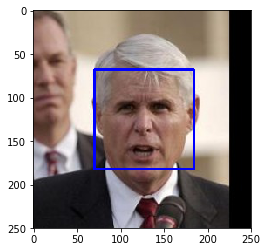

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# 提取预训练的人脸检测模型
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# 加载彩色图像，通道顺序为BGR
img = cv2.imread(human_files[0])

# 灰度处理
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 在图像中找出脸
faces = face_cascade.detectMultiScale(gray)

# 打印图像中检测到的脸的个数
print('Number of faces detected:', len(faces))
print(faces)

# 获取每一个所检测到的脸的识别框
for (x,y,w,h) in faces:
    # 在人脸图像中绘制出识别框
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

# 将BGR图像转变为RGB图像以打印
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 展示含有识别框的图像
plt.imshow(cv_rgb)
plt.show()

OpenCV读取的彩色图像是**BGR**格式，Matplotlib显示彩色图像是按照**RGB**格式，因此如果使用OpenCV读取图像，则可能无法使用Matplotlib进行正常彩色的显示，所以需要对读取的图像数据进行转换。

在使用任何一个检测模型之前，通常要将图像转换为灰度图。`detectMultiScale` 函数使用储存在 `face_cascade` 中的的数据，对输入的灰度图像进行分类。

在上方的代码中，`faces` 以 numpy 数组的形式保存识别到的面部信息。它其中每一行表示一个被检测到的脸，该数据包括如下四个信息：前两个元素  `x`、`y` 代表识别框左上角的 x 和 y 坐标；后两个元素代表识别框在 x 和 y 轴两个方向延伸的长度 `w` 和 `d`。 

### 写一个人脸识别器

In [4]:
# 如果img_path路径表示的图像检测到了脸，返回"True" 
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### 评估人脸检测模型

In [5]:
# 从每个数据集中提取前100个图像的文件路径
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

## 基于human_files_short和dog_files_short中的图像测试face_detector的表现
# print(human_files_short[0]) # /data/lfw/Rick_Dinse/Rick_Dinse_0002.jpg

def detect(detector, files):
    return sum([1 if detector(img_path) else 0 for img_path in files]) / len(files)

print('human: {:.2%}'.format(detect(face_detector, human_files_short)))
print('dog: {:.2%}'.format(detect(face_detector, dog_files_short)))

human: 100.00%
dog: 11.00%


使用OpenCV提供的分类模型进行人脸检测的结果如下：  
- `human_files` 的前100张图像中，能够检测到**人脸**的图像占比为100%。  
- `dog_files` 的前100张图像中，能够检测到**人脸**的图像占比为11%。

可见该模型对人脸的检测效果较好，对非人脸有一定的误识率，即假阳性。  
理想情况下，人图像中检测到人脸的概率应当为100%，而狗图像中检测到人脸的概率应该为0%。这个算法准确率并不是特别高，但结果仍然可以接受。

---
<a id='step2'></a>

## 步骤 2: 检测狗狗

使用预训练的残差网络模型 [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) 来检测图像中的狗。先下载 ResNet-50 模型的网络结构参数，以及基于 [ImageNet](http://www.image-net.org/) 数据集的预训练权重。

ImageNet 这目前一个非常流行的数据集，常被用来测试图像分类等计算机视觉任务相关的算法。它包含超过一千万个 URL，每一个都链接到 [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a) 中所对应的一个物体的图像。输入一个图像，该 ResNet-50 模型会返回一个对图像中物体的预测结果。

In [7]:
from keras.applications.resnet50 import ResNet50

# 定义ResNet50模型
ResNet50_model = ResNet50(weights='imagenet')

### 数据预处理

- 在使用 TensorFlow 作为后端的时候，在 Keras 中，CNN 的输入是一个4维数组（也被称作4维张量），它的各维度尺寸为 `(nb_samples, rows, columns, channels)`。其中 `nb_samples` 表示图像（或者样本）的总数，`rows`, `columns`, 和 `channels` 分别表示图像的行数、列数和通道数。


- 下方的 `path_to_tensor` 函数实现如下：将彩色图像的文件路径作为输入，返回一个4维张量，来作为 Keras CNN 的输入。因为输入图像是彩色图像，因此它们具有三个通道（ channels 为 3）。
    1. 该函数首先读取一张图像，然后将其缩放为 224×224 的图像。
    2. 随后，该图像被调整为具有4个维度的张量。
    3. 对于任一输入图像，最后返回的张量的维度是：`(1, 224, 224, 3)`。


- `paths_to_tensor` 函数将图像路径的字符串组成的 numpy 数组作为输入，并返回一个4维张量，各维度尺寸为 `(nb_samples, 224, 224, 3)`。 在这里，`nb_samples`是提供的图像路径的数据中的样本数量或图像数量。你也可以将 `nb_samples` 理解为数据集中3维张量的个数（每个3维张量表示一个不同的图像。

In [8]:
from keras.preprocessing import image                  
from tqdm import tqdm # 显示循环的进度条

def path_to_tensor(img_path):
    # 用PIL加载RGB图像为PIL.Image.Image类型
    img = image.load_img(img_path, target_size=(224, 224))
    # 将PIL.Image.Image类型转化为3维张量(224, 224, 3)
    x = image.img_to_array(img)
    # 将3维张量转化为4维张量(1, 224, 224, 3)并返回
    # return np.expand_dims(x, axis=0)
    return x.reshape((1,) + x.shape)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### 基于 ResNet-50 架构进行预测

得到四维张量后，把它们输入到 ResNet-50 网络、或 Keras 中其他类似的预训练模型之前，还需要进行一些额外的处理：
1. 首先，需要把这些图像的通道顺序由 RGB转换为 BGR。
2. 其次，预训练模型的输入都进行了额外的归一化过程。因此这里也要对这些张量进行归一化，即对所有图像所有像素都减去像素均值 `[103.939, 116.779, 123.68]`（以 RGB 模式表示，根据所有的 ImageNet 图像算出）。

导入的 `preprocess_input` 函数实现了这些功能。可以在 [这里](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py) 查看 `preprocess_input`的代码。

实现了图像处理的部分后，使用模型的 `predict` 方法来实现预测，返回一个向量，向量的第 i 个元素表示该图像属于第 i 个 ImageNet 类别的概率。

再对预测出的向量用 **argmax** 函数得到一个具有最大概率值的下标，即模型预测到的物体的类别。进而根据这个 [清单](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a) 能够知道这具体是哪个品种的狗狗。

In [9]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### 完成狗检测模型


该 [清单](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a) 中的狗类别对应的序号为151-268。因此，在检查预训练模型判断图像是否包含狗的时候，只需要检查如上的 `ResNet50_predict_labels` 函数是否返回一个介于151和268之间（包含区间端点）的值。

In [10]:
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

In [11]:
# 测试dog_detector函数在human_files_short和dog_files_short的表现

human_files_short = human_files[:100]
dog_files_short = train_files[:100]

# Test the performance of the face_detector algorithm 
# on the images in human_files_short and dog_files_short.

def detect(detector, files):
    return sum([1 if detector(img_path) else 0 for img_path in files]) / len(files)

print('human: {:.2%}'.format(detect(dog_detector, human_files_short)))
print('dog: {:.2%}'.format(detect(dog_detector, dog_files_short)))

human: 0.00%
dog: 100.00%


使用预训练的 ResNet-50 模型来检测图像中的狗的结果如下：  
- `human_files_short`中图像检测到狗狗的百分比为0。
- `dog_files_short`中图像检测到狗狗的百分比为100%。

可见该模型不管图片中是否包含狗狗，其检测准确性都非常高。

---

<a id='step3'></a>

## 步骤 3: 从头开始创建一个CNN来分类狗品种

现在能够在图像中识别人类及狗狗，然后对狗的类别进行识别。先__从头实现__一个卷积神经网络来对狗的品种进行分类。

Keras 提供了能够轻松预测每次迭代（epoch）花费时间所需的函数，可以据此推断算法所需的训练时间。

值得注意的是，对狗的图像进行分类是一项极具挑战性的任务。因为即便是一个正常人，也很难区分布列塔尼犬和威尔士史宾格犬。

布列塔尼犬（Brittany） | 威尔士史宾格犬（Welsh Springer Spaniel）
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

不难发现其他的狗品种会有很小的类间差别（比如金毛寻回犬和美国水猎犬）。


金毛寻回犬（Curly-Coated Retriever） | 美国水猎犬（American Water Spaniel）
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">

同样，拉布拉多犬（labradors）有黄色、棕色和黑色这三种。那么基于视觉的算法将不得不克服这种较高的类间差别，以达到能够将这些不同颜色的同类狗分到同一个品种中。

黄色拉布拉多犬（Yellow Labrador） | 棕色拉布拉多犬（Chocolate Labrador） | 黑色拉布拉多犬（Black Labrador）
- | - | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

不考虑品种略有失衡的影响，随机猜测到正确品种的概率是1/133，相对应的准确率是低于1%的。

### 数据预处理

通过对每张图像的像素值除以255，对图像实现了归一化处理。

In [12]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Keras中的数据预处理过程
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

print(train_tensors.shape)
print(valid_tensors.shape)
print(test_tensors.shape)

100%|██████████| 836/836 [00:08<00:00, 102.37it/s]


(6680, 224, 224, 3)
(835, 224, 224, 3)
(836, 224, 224, 3)


### 构建模型

我搭建的卷积网络构成及其作用：  
* 卷积层：提取图像特征，得到feature map堆栈。Filter更多的卷积层，可以提取到更多的特征。  
* 最大池化层：降低每个feature map的维度（高和宽），只保留最显著的特征。  
* 全局平均池化层：将最后一层卷积得到的feature map堆栈映射为向量，即每个feature map映射为一个节点。  
* Max pooling和Global Average Pooling都可以保证特征的位置与旋转不变性，减少模型参数数量，减少过拟合问题。  
* Batch normalization layer：用来解决 Covariate Shift 的问题，并加速运算过程。  
* Dropout layer：用来降低模型复杂度，增强模型的泛化能力，防止过拟合，顺带降低了运算量。  
* 全连接层：将特征输入到softmax层中进行分类。

In [13]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential

model = Sequential()

model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))
model.add(Dense(133, activation='softmax'))

# 查看模型的信息
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 16)      64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 56, 56, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        8256      
__________

In [14]:
## 编译模型
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#### 回调函数 callbacks

使用回调函数来观察训练过程中网络内部的状态和统计信息。通过传递回调函数列表到模型的 **.fit()** 中，可在给定的训练阶段调用该函数集中的函数。  ModelCheckpoint, EarlyStopping 都属于回调函数的一种。  
[Keras' callback earlystopping](http://keras-cn.readthedocs.io/en/latest/other/callbacks/#earlystopping)  
[Keras' callback modelcheckpoint](http://keras-cn.readthedocs.io/en/latest/other/callbacks/#modelcheckpoint)  
[Keras' callback history](http://keras-cn.readthedocs.io/en/latest/other/callbacks/#history)  


**earlystopping**

在有些时候继续训练会导致测试集上的准确率下降。  
继续训练导致测试准确率下降的原因可能是：1.过拟合 2.学习率过大导致不收敛 3.使用正则项时，Loss的减少可能不是因为准确率增加导致的，而是因为权重大小的降低。

让算法自动选择epoch参数，并且避免epoch过多造成过拟合，可以使用Keras中提供的 **early stopping callback（提前结束）**方法。  
early stopping 可以基于一些指定的规则自动提前结束训练过程，比如说连续指定次数epoch验证集准确率或误差都没有优化等。使用EarlyStopping可以加快学习的速度，提高调参效率。  

`keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')`  
当监测值`val_loss`不再改善时，该回调函数将中止训练。

参数：  

* monitor：需要监视的量，有`val_acc`和`val_loss`。
* patience：当early stop被激活（如发现loss相比上一个epoch训练没有下降），则经过patience个epoch后停止训练。
* verbose：信息展示模式
* mode：‘auto’，‘min’，‘max’之一，在min模式下，如果检测值停止下降则中止训练。在max模式下，当检测值不再上升则停止训练。

**modelcheckpoint**

使用模型检查点（model checkpointing）来储存具有最低验证集 loss 的模型。

**History**

```python
keras.callbacks.History()
```
Callback that records events into a `History` object.
该回调函数在Keras模型上会被自动调用，`History`对象即为`fit`方法的返回值

### 训练模型

对训练集进行 [数据增强](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)，来优化模型的表现。

In [15]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# 设置训练模型的epochs的数量
epochs = 30
batch_size = 32

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True) # 保存最佳交叉验证损失的模型权重

# model.fit(train_tensors, train_targets, 
#           validation_data=(valid_tensors, valid_targets),
#           epochs=epochs, batch_size=20, callbacks=[checkpointer, early_stopping], verbose=1)

from keras.preprocessing.image import ImageDataGenerator

# 设置数据增强的参数
datagen_train = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=20,
    vertical_flip=True,
    horizontal_flip=True)

# fit augmented image generator on data
datagen_train.fit(train_tensors)

# fits the model on batches with real-time data augmentation:
model.fit_generator(datagen_train.flow(train_tensors, train_targets, batch_size=batch_size),
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    epochs=epochs, verbose=2, callbacks=[checkpointer, early_stopping],
                    validation_data=(valid_tensors, valid_targets),
                    validation_steps=valid_tensors.shape[0] // batch_size)

Epoch 1/30
Epoch 00001: val_loss improved from inf to 4.88740, saving model to saved_models/weights.best.from_scratch.hdf5
 - 53s - loss: 4.9113 - acc: 0.0102 - val_loss: 4.8874 - val_acc: 0.0144
Epoch 2/30
Epoch 00002: val_loss improved from 4.88740 to 4.87518, saving model to saved_models/weights.best.from_scratch.hdf5
 - 51s - loss: 4.7904 - acc: 0.0228 - val_loss: 4.8752 - val_acc: 0.0144
Epoch 3/30
Epoch 00003: val_loss improved from 4.87518 to 4.69206, saving model to saved_models/weights.best.from_scratch.hdf5
 - 52s - loss: 4.6974 - acc: 0.0305 - val_loss: 4.6921 - val_acc: 0.0311
Epoch 4/30
Epoch 00004: val_loss improved from 4.69206 to 4.54844, saving model to saved_models/weights.best.from_scratch.hdf5
 - 52s - loss: 4.6038 - acc: 0.0379 - val_loss: 4.5484 - val_acc: 0.0503
Epoch 5/30
Epoch 00005: val_loss did not improve
 - 52s - loss: 4.5290 - acc: 0.0439 - val_loss: 4.6293 - val_acc: 0.0383
Epoch 6/30
Epoch 00006: val_loss did not improve
 - 52s - loss: 4.4542 - acc: 0.04

In [16]:
## 加载具有最好验证loss的模型
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### 测试模型

在狗图像的测试数据集上对模型进行测试。

In [17]:
# 获取测试数据集中每一个图像所预测的狗品种的index
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# 报告测试准确率
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 15.4306%


**提高准确率的技巧：**  
可以使劲往上加层，直到它在测试集上过拟合，然后再加正则化和数据增强等抑制过拟合。  
如果不过拟合了，再接着往上加层。

---
<a id='step4'></a>
## 步骤 4: 使用一个CNN来区分狗的品种


使用 迁移学习（Transfer Learning）可以在不损失准确率的情况下大大减少训练时间。

### 得到从图像中提取的特征向量（Bottleneck Features）

把预训练好的模型看作一个固定的函数映射，让原始图像通过该函数映射得到特征向量。

In [18]:
bottleneck_features = np.load('/data/bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### 模型架构

该模型使用预训练的 VGG-16 模型作为固定的图像特征提取器，其中 VGG-16 最后一层卷积层的输出被直接输入到我们的模型。我们只需要添加一个全局平均池化层以及一个全连接层，其中全连接层使用 softmax 激活函数，每一个狗的种类都包含一个节点。

In [19]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


In [20]:
## 编译模型
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [21]:
## 训练模型

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets), verbose=1,
          epochs=30, batch_size=20, callbacks=[checkpointer, early_stopping])

Train on 6680 samples, validate on 835 samples
Epoch 1/30
6680/6680 [==============================] - 2s 290us/step - loss: 11.9936 - acc: 0.1409 - val_loss: 10.4910 - val_acc: 0.2395
Epoch 2/30
6680/6680 [==============================] - 2s 238us/step - loss: 9.9490 - acc: 0.2954 - val_loss: 9.8390 - val_acc: 0.2910
Epoch 3/30
6680/6680 [==============================] - 2s 248us/step - loss: 9.4250 - acc: 0.3518 - val_loss: 9.5405 - val_acc: 0.3257
Epoch 4/30
6680/6680 [==============================] - 2s 245us/step - loss: 9.1697 - acc: 0.3805 - val_loss: 9.4959 - val_acc: 0.3389
Epoch 5/30
6680/6680 [==============================] - 2s 246us/step - loss: 9.0415 - acc: 0.4031 - val_loss: 9.4411 - val_acc: 0.3509
Epoch 6/30
6680/6680 [==============================] - 2s 245us/step - loss: 8.9618 - acc: 0.4159 - val_loss: 9.3130 - val_acc: 0.3629
Epoch 7/30
6680/6680 [==============================] - 2s 246us/step - loss: 8.8875 - acc: 0.4256 - val_loss: 9.3094 - val_acc: 0.3593

Epoch 00027: early stopping


In [22]:
## 加载具有最好验证loss的模型
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### 测试模型
测试此CNN模型在狗图像测试数据集中识别品种的效果。

可以发现训练时间大大减少，而且准确率提高了很多。

In [23]:
# 获取测试数据集中每一个图像所预测的狗品种的index
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# 报告测试准确率
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 43.5407%


### 使用模型预测狗的品种

In [24]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # 提取bottleneck特征
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # 获取预测向量
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # 返回此模型预测的狗的品种
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## 步骤 5: 建立一个CNN来分类狗的品种

使用迁移学习来建立一个CNN，从而可以从图像中识别狗的品种。在步骤4中，使用了迁移学习来创建一个基于 VGG-16 提取的特征向量来搭建一个 CNN。在本部分内容中，使用另一个预训练模型来搭建一个 CNN。为了让这个任务更易实现，已经预先对目前 keras 中可用的几种网络进行了预训练：

- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

这些文件被命名为为：

    Dog{network}Data.npz

其中 `{network}` 可以是 `VGG19`、`Resnet50`、`InceptionV3` 或 `Xception` 中的一个。选择上方网络架构中的一个，下载相对应的bottleneck特征，并将所下载的文件保存在目录 `/data/bottleneck_features/` 中。

### 获取模型的特征向量

运行下方代码提取训练、测试与验证集相对应的bottleneck特征。
```python
bottleneck_features = np.load('/data/bottleneck_features/Dog{network}Data.npz')
train_{network} = bottleneck_features['train']
valid_{network} = bottleneck_features['valid']
test_{network} = bottleneck_features['test']
```
当下比较主流的架构是**ResNet-50**和**Xception**，容易达到80%以上的准确率。

In [25]:
### 从另一个预训练的CNN获取bottleneck特征

bottleneck_features = np.load('/data/bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

print(train_Resnet50.shape)
print(valid_Resnet50.shape)
print(test_Resnet50.shape)

(6680, 1, 1, 2048)
(835, 1, 1, 2048)
(836, 1, 1, 2048)


### 定义模型架构

建立一个CNN来分类狗品种。

我选择使用Resnet50网络架构，是因为Resnet50只是在CNN上面增加了跳过层级的连接，和CNN还是很相似的，但是其使梯度信号的传播路径更短，避免了梯度消失的影响。

* 全局平均池化层：将网络模型`Resnet50`的输出作为输入，将其feature map堆栈映射为向量，即每个feature map映射为一个节点，可以防止过拟合。  
* 全连接层：将特征输入到softmax层中进行分类。  
* 这个CNN架构的分类效果比较好，因为这是在已经训练好的网络模型`Resnet50`的基础上添加我自己的分类输出层。
* 在第三步中，要达到如模型`Resnet50`这样好的效果，需要使用大量的图像数据（如ImageNet），和足够深度的网络模型，并且训练特别长的时间。自己从头构建的一个CNN分类模型，模型深度不够，训练时间过短，导致特征提取不充分，所以准确率不高。
* 在第四步中，`VGG16`模型的效果欠佳，是因为其深度远不及`Resnet50`模型的深度，同时`Resnet50`模型还采用残差网络解决网络过深出现的梯度消失问题，在没有给网络增加额外的参数和计算量的情况下，可以大大增加了模型的训练速度、提高了训练效果。

In [72]:
from keras import regularizers

Resnet50_model = Sequential()
Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
model.add(Dropout(0.4))
model.add(BatchNormalization())

Resnet50_model.add(Dense(133, activation='softmax'))

Resnet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_11  (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


In [73]:
### TODO: 编译模型
Resnet50_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### 训练模型

In [74]:
epochs=30
batch_size=32

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True)

history = Resnet50_model.fit(train_Resnet50, train_targets,
                   validation_data=(valid_Resnet50, valid_targets),
                   epochs=30, batch_size=20, verbose=1,
                   callbacks=[checkpointer, early_stopping])

Train on 6680 samples, validate on 835 samples
Epoch 1/30
6680/6680 [==============================] - 4s 548us/step - loss: 1.7022 - acc: 0.5933 - val_loss: 0.8496 - val_acc: 0.7521
Epoch 2/30
6680/6680 [==============================] - 2s 260us/step - loss: 0.3498 - acc: 0.9127 - val_loss: 0.7186 - val_acc: 0.7880
Epoch 3/30
6680/6680 [==============================] - 2s 264us/step - loss: 0.1642 - acc: 0.9684 - val_loss: 0.6391 - val_acc: 0.8048
Epoch 4/30
6680/6680 [==============================] - 2s 265us/step - loss: 0.0890 - acc: 0.9883 - val_loss: 0.6013 - val_acc: 0.8204
Epoch 5/30
6680/6680 [==============================] - 2s 263us/step - loss: 0.0562 - acc: 0.9943 - val_loss: 0.5697 - val_acc: 0.8347
Epoch 6/30
6680/6680 [==============================] - 2s 261us/step - loss: 0.0372 - acc: 0.9967 - val_loss: 0.5793 - val_acc: 0.8228
Epoch 7/30
6680/6680 [==============================] - 2s 261us/step - loss: 0.0311 - acc: 0.9969 - val_loss: 0.5833 - val_acc: 0.8263
E

**Keras在训练期间可视化训练误差和验证误差**

可视化训练过程中的loss曲线和accuracy曲线，具体参考[Display Deep Learning Model Training History in Keras](https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/)这篇文章，这样可以让训练过程更为直观，可以更方便地判断模型是否出现了欠拟合或过拟合。 

`fit()` 方法会返回一个训练期间历史数据记录对象，包含 `training error`, `training accuracy`, `validation error`, `validation accuracy` 字段。

```python
history = model.fit()
# list all data in history
print(history.history.keys())
# output:
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
```

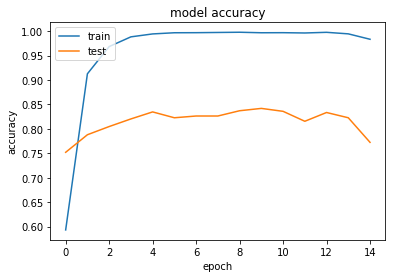

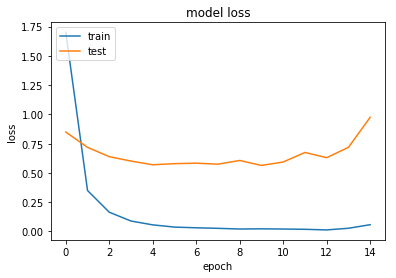

In [75]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [76]:
# 加载具有最佳验证loss的模型权重
Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

### 测试模型

在狗图像的测试数据集上测试模型，测试准确率大于80%。

In [77]:
### TODO: 在测试集上计算分类准确率

Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

test_accuracy = 100 * np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 84.0909%


---

### 使用模型测试狗的品种

实现一个函数，它的输入为图像路径，功能为预测对应图像的类别，输出为模型预测出的狗类别。

与步骤5中的模拟函数类似，包含如下三个步骤：

1. 根据选定的模型载入图像特征（bottleneck features）
2. 将图像特征输输入到你的模型中，并返回预测向量。注意，在该向量上使用 argmax 函数可以返回狗种类的序号。
3. 使用在步骤0中定义的 `dog_names` 数组来返回对应的狗种类名称。

提取图像特征过程中使用到的函数可以在 `extract_bottleneck_features.py` 中找到。同时，它们应已在之前的代码块中被导入。根据选定的 CNN 网络，使用 `extract_{network}` 函数来获得对应的图像特征，其中 `{network}` 代表 `VGG19`, `Resnet50`, `InceptionV3`, 或 `Xception` 中的一个。

In [78]:
# 该函数将图像的路径作为输入，返回此模型所预测的狗的品种

from extract_bottleneck_features import *

def Resnet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Resnet50_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---

<a id='step6'></a>
## 步骤 6: 完成最终算法

编写检测图像中人类与狗的函数，输入为图像的路径，能够区分图像是否包含一个人、狗或两者都不包含，使用上面的 `face_detector` 和 `dog_detector` 函数。

- 如果从图像中检测到一只__狗__，返回被预测的品种。
- 如果从图像中检测到__人__，返回最相像的狗品种。
- 如果两者都不能在图像中检测到，输出错误提示。

In [79]:
def dog_recognition(img_path):
    # 先判断dog后判断face，因为前者的准确率更高
    if dog_detector(img_path) == True:
        print('* This is a dog! Its breed is ...')
    elif face_detector(img_path) == True:
        print('* Hello human! You look like a ...')
    else:
        return False

    return Resnet50_predict_breed(img_path)

---
<a id='step7'></a>
## 步骤 7: 测试算法

使用任意至少6张图片，至少使用两张人类图片和两张狗的图片来测试算法。

结论分析：
1. 对于猫狗的预测都是正确的，对于找出和人最像的狗狗种类，感觉不是很像。
2. 模型改进：
 * 检测人脸是使用OpenCV提供的分类器模型，该模型对于非人的图像的存在一定误差，所以检测人脸的模型也可以通过迁移学习来构建。  
 * 从loss图可以看出该模型有过拟合的情况，使用迁移学习时可以试着减少`Resnet50`模型的层数以减小模型的复杂度。  
 * 可以通过随机地平移或旋转已有图像数据以获取性能的提升，提高模型的泛化能力。  
 
 [what-dog](https://www.what-dog.net/#)

* This is not dog or human.
* This is not dog or human.
* This is a dog! Its breed is ...
   in/016.Beagle
* This is a dog! Its breed is ...
   in/029.Border_collie
* This is a dog! Its breed is ...
   in/115.Papillon
* Hello human! You look like a ...
   in/063.English_springer_spaniel
* Hello human! You look like a ...
   in/127.Silky_terrier


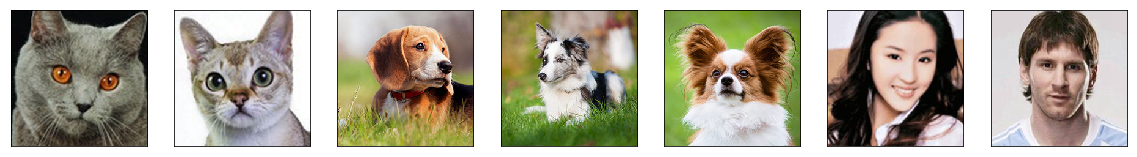

In [80]:
## TODO: 在你的电脑上，在步骤6中，至少在6张图片上运行你的算法。
## 自由地使用所需的代码单元数吧
path = []
imgs = []
for i in range(7):
    path.append('images/image'+str(i+1)+'.jpg')
    img = cv2.imread(path[i])
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgs.append(cv_rgb)

fig = plt.figure(figsize=(20,5))
for i in range(7):
    ax = fig.add_subplot(1, 7, i + 1, xticks=[], yticks=[])
    ax.imshow(imgs[i])

    result = dog_recognition(path[i])
    if result != False:
        print('  ', result)
    else:
        print('* This is not dog or human.')